In [20]:
import csv
import os
#to install fitparse, run 
#sudo pip3 install -e git+https://github.com/dtcooper/python-fitparse#egg=python-fitparse
import fitparse
import pytz
from datetime import datetime
import datetime as DT
allowed_fields = ['timestamp','heart_rate','timestamp_16']
required_fields = ['heart_rate']

UTC = pytz.UTC


def main():
    files = os.listdir(os.getcwd()+'/data')
    fit_files = [file for file in files if file[-4:].lower()=='.fit']
    for file in fit_files:
        new_filename = os.getcwd()+'/data/'+file[:-4] + '.csv'
        if os.path.exists(new_filename):
            print('%s already exists. skipping.' % new_filename)
            continue
        fitfile = fitparse.FitFile(os.getcwd()+'/data/'+file,  
            data_processor=fitparse.StandardUnitsDataProcessor())
        
        print('converting %s' % file)
        write_fitfile_to_csv(fitfile, new_filename)
    print('finished conversions')

epoch = datetime.utcfromtimestamp(0)
def unix_time_s(dt):
    return (dt - epoch).total_seconds()

def write_fitfile_to_csv(fitfile, output_file='test_output.csv'):
    messages = fitfile.messages
    data = []
    timestamp_16_found = False
    initial_timestamp = None
    initial_timestamp_16 = None
    last_timestamp = None
    counter = 0
    for i,m in enumerate(messages):
        
        skip=False
        if not hasattr(m, 'fields'):
            continue
        fields = m.fields
        #check for important data types
        mdata = {}
#         print(i, fields)
#         print('--')
        for field in fields:
            
            if field.name in allowed_fields:
                if field.name=='timestamp' and timestamp_16_found is False :
                    initial_timestamp = unix_time_s(field.value)
                    #mdata['timestamp'] = field.value # fill in the value with the timestamp. 
                if field.name=='timestamp_16':
                    if timestamp_16_found is False:
                        timestamp_16_found = True
                        initial_timestamp_16 = field.value
                    else:
                        # this is in seconds since epoch
                        mdata['timestamp_s'] = initial_timestamp + (field.value - initial_timestamp_16)
                        mdata['timestamp'] = datetime.utcfromtimestamp(mdata['timestamp_s']).strftime('%Y-%m-%d %H:%M:%S')
                        
                mdata[field.name] = field.value
            
        
        for rf in required_fields:
            if rf not in mdata:
                skip=True
                
        print(mdata)
        print('--')
        
        try:
            #print(last_timestamp, mdata['timestamp_s'])
            if last_timestamp is None:
                last_timestamp = mdata['timestamp_s']
            #print(i,last_timestamp > mdata['timestamp_s'])
            if last_timestamp > mdata['timestamp_s']:
                skip = True
        except:
            pass
        
        if not skip:
            counter += 1
            
            data.append(mdata)

    
    #write to csv
    with open(output_file, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(allowed_fields)
        for entry in data:
            writer.writerow([ str(entry.get(k, '')) for k in allowed_fields])
    print('wrote %s' % output_file)

main()

converting chris.fit
{}
--
{'timestamp': datetime.datetime(2020, 5, 6, 10, 24)}
--
{}
--
{'timestamp': datetime.datetime(2020, 5, 6, 10, 24)}
--
{'timestamp': datetime.datetime(2020, 5, 6, 10, 24)}
--
{'timestamp': datetime.datetime(2020, 5, 6, 10, 24)}
--
{'timestamp': datetime.datetime(2020, 5, 6, 10, 24)}
--
{'timestamp': datetime.datetime(2020, 5, 6, 10, 24)}
--
{'timestamp': datetime.datetime(2020, 5, 6, 10, 24)}
--
{}
--
{'timestamp_16': 17532, 'heart_rate': 92}
--
{'timestamp_s': 1588760700.0, 'timestamp': '2020-05-06 10:25:00', 'timestamp_16': 17592, 'heart_rate': 91}
--
{'timestamp_s': 1588760700.0, 'timestamp': '2020-05-06 10:25:00', 'timestamp_16': 17592}
--
{'timestamp_s': 1588760760.0, 'timestamp': '2020-05-06 10:26:00', 'timestamp_16': 17652, 'heart_rate': 86}
--
{'timestamp': datetime.datetime(2020, 5, 6, 10, 27)}
--
{'timestamp_s': 1588760820.0, 'timestamp': '2020-05-06 10:27:00', 'timestamp_16': 17712, 'heart_rate': 96}
--
{'timestamp_s': 1588760880.0, 'timestamp': '20

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md

def ingest(filename):
    df = pd.read_csv(filename).fillna(value = 0)
    df = df.dropna()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df=df.sort_values('timestamp')
    return df


def plot(df, filename):
    ax=plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    plt.xticks( rotation=25 )
    plt.plot(df['timestamp'],df['heart_rate'])
    plt.gcf().subplots_adjust(bottom=0.5)
    #plt.savefig(filename.replace('.csv',''))
    plt.show()


def calc_points(df, filename):
    
    past_r = None
    total_points = 0
    for r in df.iterrows():
        if past_r is not None:
            t_delta = (r[1]['timestamp'] - past_r[1]['timestamp']).total_seconds() /60
            points = r[1]['heart_rate'] * t_delta
            total_points += points
        past_r = r

    return total_points

files = os.listdir(os.getcwd()+'/data')
csv_files = [file for file in files if file[-4:].lower()=='.csv']

class friend:
    def __init__(self, name, resting_hr):
        self.name = name
        self.resting_hr = resting_hr
        self.points = 1
        
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)
        
        
friends = [friend('kacy', 60), friend('chris', 60), friend('oli', 60), friend('galen', 60), friend('tom ', 60), friend('mitchell', 60), friend('sholto', 60)]


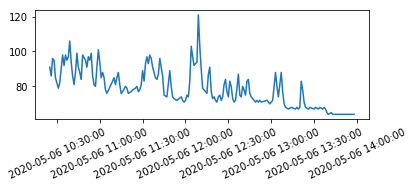

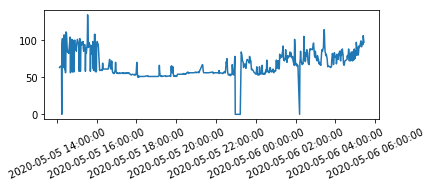

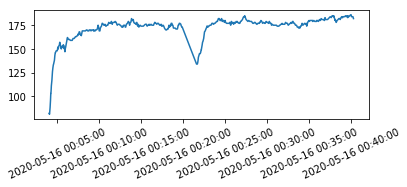

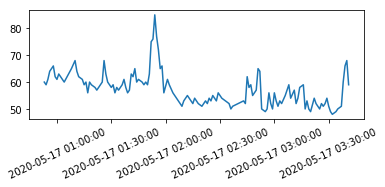

In [62]:
files = os.listdir(os.getcwd()+'/data')
csv_files = [file for file in files if file[-4:].lower()=='.csv']

for c in csv_files:
    filename = 'data/'+c
    try:
        df = ingest(filename)[1:]
        if len(df) > 0:
            plot(df, filename)
            points = calc_points(df, filename)
        for f in friends:
            if f.name in filename:
                f.points += points
    except:
        pass

In [70]:
from tempfile import mkstemp
from shutil import move, copymode
from os import fdopen, remove

def replace(file_path):
    #Create temp file
    fh, abs_path = mkstemp()
    with fdopen(fh,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                wrote_new = False
                for f in friends:
                    
                    if f.name in line:
                        print(f)
                        new_line = '        {  "name":"'+f.name +'", "value":'+str(int(f.points))
                        if ',}];' in line:
                            new_line += ',}];\n'
                        else:
                            new_line += ',},\n'
                        
                        print(new_line)
                        new_file.write(new_line)
                        wrote_new = True
                        
                if not wrote_new:
                    new_file.write(line)
    #Copy the file permissions from the old file to the new file
    copymode(file_path, abs_path)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

replace("index.html")

<class '__main__.friend'>: {'name': 'sholto', 'resting_hr': 60, 'points': 1}
        {  "name":"sholto", "value":1,},

<class '__main__.friend'>: {'name': 'chris', 'resting_hr': 60, 'points': 77586.8}
        {  "name":"chris", "value":77586,},

<class '__main__.friend'>: {'name': 'oli', 'resting_hr': 60, 'points': 1}
        {  "name":"oli", "value":1,},

<class '__main__.friend'>: {'name': 'tom ', 'resting_hr': 60, 'points': 1}
        {  "name":"tom ", "value":1,},

<class '__main__.friend'>: {'name': 'galen', 'resting_hr': 60, 'points': 1}
        {  "name":"galen", "value":1,},

<class '__main__.friend'>: {'name': 'mitchell', 'resting_hr': 60, 'points': 1}
        {  "name":"mitchell", "value":1,},

<class '__main__.friend'>: {'name': 'kacy', 'resting_hr': 60, 'points': 25417.616666666665}
        {  "name":"kacy", "value":25417,}];



In [65]:
for f in friends:
    print(f.name)

kacy
chris
oli
galen
tom 
mitchell
sholto


In [24]:
filename = 'data/chris.csv'
df = pd.read_csv(filename).fillna(value = 0)
df = df.dropna()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df=df.sort_values('timestamp')



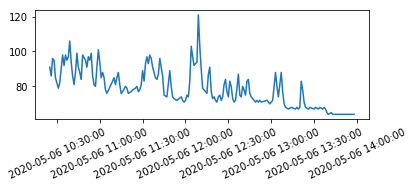

In [25]:
ax=plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.xticks( rotation=25 )
plt.plot(df['timestamp'],df['heart_rate'])
plt.gcf().subplots_adjust(bottom=0.5)
plt.savefig(filename.replace('.csv',''))
plt.show()


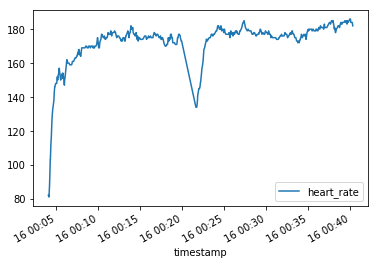

In [32]:
import matplotlib.dates as mdates
ax = df.plot(x='timestamp', y= 'heart_rate')
# set monthly locator
# ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
# # set formatter
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# # set font and rotation for date tick labels
# plt.gcf().autofmt_xdate()

plt.show()

'kacy'

In [52]:
len(df)

508

In [58]:
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)



6207.983333333333


In [41]:
r[1]



timestamp       2020-05-16 00:04:03
heart_rate                       82
timestamp_16                      0
Name: 0, dtype: object